In [1]:
import fastai
from fastai.vision.all import *
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 85
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

In [3]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Define Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

def load_labels(csv_path, image_path):
    """
    Loads and preprocesses the labels from the CSV file.
    Maps each image to its corresponding file path and binary labels for each disease.
    """

    # Read the CSV file containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create a binary column for 'No Finding'
    labels_df['No_Finding'] = labels_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

    # Map image filenames to their full paths
    image_paths = glob(os.path.join(image_path, '**', 'images', '*.png'), recursive=True)
    img_path_dict = {os.path.basename(path): path for path in image_paths}

    # Add the full image path to the dataframe
    labels_df['Path'] = labels_df['Image Index'].map(img_path_dict)
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
labels_df = load_labels(labels_csv_path, EXTRACTED_PATH)

In [4]:
labels_df=labels_df[labels_df['Finding Labels'] != 'No Finding']

In [5]:
# Split patients into training/validation and test sets
unique_patients = labels_df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)

# Create training/validation and test dataframes
train_val_df = labels_df[labels_df['Patient ID'].isin(train_val_patients)].reset_index(drop=True)
test_df = labels_df[labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {train_val_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}")

Train size: 41721
Test size: 10038


In [6]:
item_transforms = [
    Resize((224, 224)),
]

batch_transforms = [
    Flip(),
    Rotate(),
    Normalize.from_stats(*imagenet_stats),
]


def get_x(row):
    return row['Path']

def get_y(row):
    labels = row[disease_labels].tolist()
    return labels

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True,vocab=disease_labels)),
                   splitter=RandomSplitter(valid_pct=0.125, seed=SEED),
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=item_transforms,
                   batch_tfms=batch_transforms
                  )
dls = dblock.dataloaders(train_val_df, bs=32)
# print(dblock.datasets(train_val_merge).train)

In [7]:
from fastai.vision.all import *

arch = 'coatnet_2_rw_224.sw_in12k_ft_in1k'

cbs=[
    SaveModelCallback(monitor='valid_loss', min_delta=0.001, with_opt=True),
    EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5),
    ShowGraphCallback()
    ]

learn = vision_learner(dls, arch, metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()],cbs=cbs, wd=0.001)

learn.model = torch.nn.DataParallel(learn.model)

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, ma

intial learning rate= 0.0020892962347716093


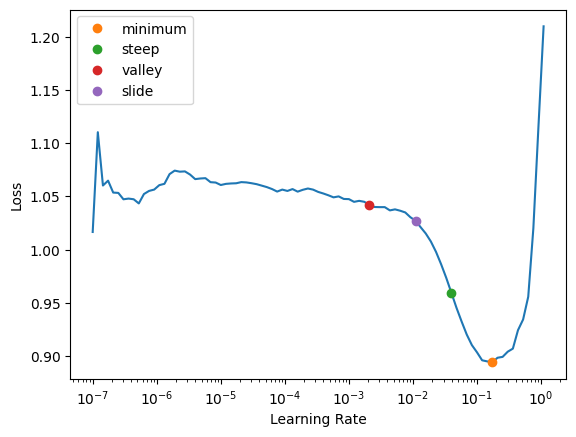

In [8]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print('intial learning rate=', lrs.valley)

In [9]:
# learn.fine_tune(freeze_epochs=3,epochs=20, base_lr=lrs.valley)

In [10]:
# learn.save('coatnet-70-10-20-split')

In [11]:
from glob import glob

# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Define Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

def load_labels(csv_path, image_path):
    """
    Loads and preprocesses the labels from the CSV file.
    Maps each image to its corresponding file path and binary labels for each disease.
    """

    # Read the CSV file containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create a binary column for 'No Finding'
    labels_df['No_Finding'] = labels_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

    # Map image filenames to their full paths
    image_paths = glob(os.path.join(image_path, '**', 'images', '*.png'), recursive=True)
    img_path_dict = {os.path.basename(path): path for path in image_paths}

    # Add the full image path to the dataframe
    labels_df['Path'] = labels_df['Image Index'].map(img_path_dict)
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
labels_df = load_labels(labels_csv_path, EXTRACTED_PATH)

In [12]:
# Split patients into training/validation and test sets
unique_patients = labels_df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)

# Create training/validation and test dataframes
train_val_df = labels_df[labels_df['Patient ID'].isin(train_val_patients)].reset_index(drop=True)
test_df = labels_df[labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {train_val_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}")

Train size: 89764
Test size: 22356


In [13]:
item_transforms = [
    Resize((224, 224)),
]

batch_transforms = [
    Flip(),
    Rotate(),
    Normalize.from_stats(*imagenet_stats),
]


def get_x(row):
    return row['Path']

def get_y(row):
    labels = row[disease_labels].tolist()
    return labels

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True,vocab=disease_labels)),
                   splitter=RandomSplitter(valid_pct=0.125, seed=SEED),
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=item_transforms,
                   batch_tfms=batch_transforms
                  )
dls = dblock.dataloaders(train_val_df, bs=32)
# print(dblock.datasets(train_val_merge).train)

In [14]:
from fastai.vision.all import *

arch = 'coatnet_2_rw_224.sw_in12k_ft_in1k'

cbs=[
    SaveModelCallback(monitor='valid_loss', min_delta=0.001, with_opt=True),
    EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=2),
    ShowGraphCallback()
    ]

learn = vision_learner(dls, arch, metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()],cbs=cbs)
learn = learn.load('../models/model')

learn.model = torch.nn.DataParallel(learn.model)

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, ma

In [15]:
learn.unfreeze()
# learn.fit_one_cycle(5, slice(2e-5, 8e-5))

In [16]:
# learn.save('coatnet-stage2')
learn = learn.load('../models/coatnet-stage2')

**Evaluation**

In [17]:
from sklearn.metrics import roc_auc_score

# Create a test dataloader
test_dl = dls.test_dl(test_df, with_labels=True)

# Get predictions and targets from the test set
# Use torch.sigmoid to convert to probabilities.
preds, targs = learn.get_preds(dl=test_dl, act=torch.sigmoid)

# Compute the macro-averaged ROC AUC score for multi-label classification
roc_auc = roc_auc_score(targs.cpu().numpy(), preds.cpu().numpy(), average="macro")
print(f"Test ROC AUC: {roc_auc:.4f}")


Test ROC AUC: 0.8567


**Evaluation with Test-time Augmentation (TTA)**

In [18]:
# Create a test dataloader with labels
test_dl = dls.test_dl(test_df, with_labels=True)

# Use test time augmentation (TTA) to get predictions
tta_preds, tta_targs = learn.tta(dl=test_dl, n=25, beta=0.9)

# Apply the sigmoid activation to convert logits to probabilities
tta_preds = torch.sigmoid(tta_preds)

# Compute the macro-averaged ROC AUC score for multi-label classification
roc_auc = roc_auc_score(tta_targs.cpu().numpy(), tta_preds.cpu().numpy(), average="macro")
print(f"Test ROC AUC (TTA): {roc_auc:.4f}")

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, ma

Test ROC AUC (TTA): 0.8575
